# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [2]:
import Pkg; Pkg.add("PyPlot")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed PyPlot ─ v2.11.6
   Installed PyCall ─ v1.96.4
    Updating `~/.julia/environments/v1.10/Project.toml`
  [d330b81b] + PyPlot v2.11.6
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [438e738f] + PyCall v1.96.4
  [d330b81b] + PyPlot v2.11.6
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`
Precompiling packages...
  10017.9 ms  ✓ PyCall
   2505.9 ms  ✓ PyPlot
  2 dependencies successfully precompiled in 24 seconds. 462 already precompiled.


In [4]:
using Pkg
Pkg.add(["DifferentialEquations", "Flux", "DiffEqFlux", "Optimization",
         "OptimizationOptimJL", "ComponentArrays", "BSON", "Zygote"])

   Resolving package versions...
   Installed OrdinaryDiffEqRKN ─────────────────── v1.1.0
   Installed OrdinaryDiffEqRosenbrock ──────────── v1.11.0
   Installed ConsoleProgressMonitor ────────────── v0.1.2
   Installed ShowCases ─────────────────────────── v0.1.0
   Installed ContextVariablesX ─────────────────── v0.1.3
   Installed DifferentialEquations ─────────────── v7.16.1
   Installed NonlinearSolve ────────────────────── v4.9.0
   Installed OrdinaryDiffEqStabilizedRK ────────── v1.1.0
   Installed TimerOutputs ──────────────────────── v0.5.29
   Installed Accessors ─────────────────────────── v0.1.42
   Installed BoundaryValueDiffEqFIRK ───────────── v1.8.1
   Installed AlmostBlockDiagonals ──────────────── v0.1.10
   Installed FastGaussQuadrature ───────────────── v1.0.2
   Installed SciMLSensitivity ──────────────────── v7.85.0
   Installed OrdinaryDiffEqSDIRK ───────────────── v1.3.0
   Installed SciMLJacobianOperators ────────────── v0.1.6
   Installed OrdinaryDiffEqPRK ──

In [6]:
using Pkg
Pkg.add([
    "OrdinaryDiffEq",
    "OptimizationOptimisers",
    "Plots",
    "Random",
    "LinearAlgebra",
    "Statistics",
    "Printf"
])

   Resolving package versions...
   Installed OptimizationOptimisers ─ v0.3.7
    Updating `~/.julia/environments/v1.10/Project.toml`
  [42dfb2eb] + OptimizationOptimisers v0.3.7
  [1dea7af3] + OrdinaryDiffEq v6.98.0
  [37e2e46d] + LinearAlgebra
  [de0858da] + Printf
  [9a3f8284] + Random
  [10745b16] + Statistics v1.10.0
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [42dfb2eb] + OptimizationOptimisers v0.3.7
Precompiling packages...
   2460.4 ms  ✓ OptimizationOptimisers
  1 dependency successfully precompiled in 6 seconds. 764 already precompiled.


In [8]:
using LinearAlgebra
using Statistics
using Random

sys:1: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
[ Info: Saved animation to /content/tdse_data/tdse_true.gif


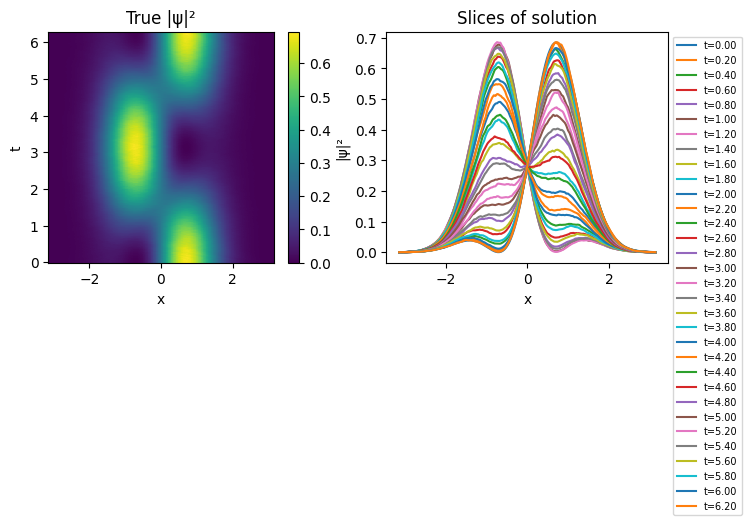

Plots.AnimatedGif("/content/tdse_data/tdse_true.gif")
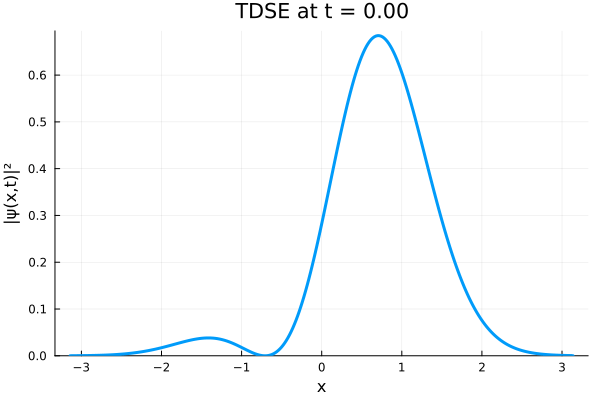

In [9]:
using PyPlot
using Printf
using LinearAlgebra
using Flux, DiffEqFlux
using OrdinaryDiffEq
using ComponentArrays
using Random
using BSON: @save, @load
using Optimization, OptimizationOptimJL, OptimizationOptimisers
using Statistics
using Plots
gr()

# Ensure variables are defined only once
let
    # Parameters
    global ω = 1.0            # Harmonic oscillator frequency
    global X = π              # Spatial domain: [-π, π]
    global T = 2π             # Time domain: [0, 2π]
    global dx = 0.02          # Spatial step
    global dt = 0.02          # Time step
    global x = collect(-X:dx:X)
    global t = collect(0:dt:T)
    global Nx = length(x)
    global Nt = length(t)
end

# Save folder
save_folder = "tdse_data"
if isdir(save_folder)
    rm(save_folder, recursive=true)
end
mkdir(save_folder)

# Hermite polynomials for analytical solution
function hermite(n, x)
    if n == 0
        return 1.0
    elseif n == 1
        return 2x
    else
        H_prev2 = 1.0
        H_prev1 = 2x
        for i in 2:n
            H_current = 2x * H_prev1 - 2(i-1) * H_prev2
            H_prev2 = H_prev1
            H_prev1 = H_current
        end
        return H_prev1
    end
end

# Eigenstates of the harmonic oscillator
function φ_n(n, x, ω)
    norm = sqrt(sqrt(ω/π) / (2^n * factorial(n)))
    return norm * hermite(n, sqrt(ω)*x) * exp(-ω*x^2/2)
end

# Initial condition: superposition of ground and first excited states
u0 = @. (φ_n(0, x, ω) + φ_n(1, x, ω)) / sqrt(2)
v0 = zeros(Nx)
u0[1] = 0.0; u0[end] = 0.0
v0[1] = 0.0; v0[end] = 0.0

# Laplacian matrix with Dirichlet BC
lap = diagm(0 => -2.0 * ones(Nx),
            1 => ones(Nx-1),
           -1 => ones(Nx-1)) / dx^2
lap[1, :] .= 0.0
lap[1, 1] = -2.0 / dx^2
lap[1, 2] = 1.0 / dx^2
lap[end, :] .= 0.0
lap[end, end] = -2.0 / dx^2
lap[end, end-1] = 1.0 / dx^2

# TDSE RHS for true solution
function tdse_rhs!(du, u_vec, p, t)
    u = @view u_vec[1:Nx]
    v = @view u_vec[Nx+1:end]
    d2u_dx2 = lap * u
    d2v_dx2 = lap * v
    @inbounds for i in 1:Nx
        pot = 0.5 * ω^2 * x[i]^2
        du[i] = -0.5 * d2v_dx2[i] + pot * v[i]
        du[Nx+i] = 0.5 * d2u_dx2[i] - pot * u[i]
    end
    du[1] = 0.0; du[Nx] = 0.0
    du[Nx+1] = 0.0; du[2*Nx] = 0.0
end

# Solve true TDSE
prob_data = ODEProblem(tdse_rhs!, vcat(u0, v0), (0.0, T))
sol_data = solve(prob_data, Tsit5(), saveat=t, abstol=1e-10, reltol=1e-10)
ode_data = Array(sol_data)
u_data = ode_data[1:Nx, :]
v_data = ode_data[Nx+1:end, :]
prob_density = u_data.^2 + v_data.^2

# Plot true solution
fig = figure(figsize=(8,3))
sub1 = fig.add_subplot(1,2,1)
pcolormesh(x, t, prob_density', cmap="viridis")
sub1.set_xlabel("x")
sub1.set_ylabel("t")
fig.colorbar(PyPlot.gci(), ax=sub1)
sub1.set_title("True |ψ|²")

sub2 = fig.add_subplot(1,2,2)
for i in 1:10:Nt
    sub2.plot(x, prob_density[:, i], label=@sprintf("t=%.2f", t[i]))
end
sub2.set_xlabel("x")
sub2.set_ylabel("|ψ|²")
sub2.legend(fontsize=7, loc="upper left", bbox_to_anchor=(1,1))
sub2.set_title("Slices of solution")
tight_layout()
fig.savefig(joinpath(save_folder, "tdse_training_data.pdf"))

# Analytical solution for comparison
u_analytical = zeros(Nx, Nt)
v_analytical = zeros(Nx, Nt)
for j in 1:Nt
    for i in 1:Nx
        φ0 = φ_n(0, x[i], ω)
        φ1 = φ_n(1, x[i], ω)
        E0 = ω/2
        E1 = 3ω/2
        u_analytical[i,j] = (φ0 * cos(E0*t[j]) + φ1 * cos(E1*t[j])) / sqrt(2)
        v_analytical[i,j] = (-φ0 * sin(E0*t[j]) - φ1 * sin(E1*t[j])) / sqrt(2)
    end
end
u_analytical[1, :] .= 0.0; u_analytical[end, :] .= 0.0
v_analytical[1, :] .= 0.0; v_analytical[end, :] .= 0.0
prob_analytical = u_analytical.^2 + v_analytical.^2

# Animate true solution
anim = @animate for i in 1:Nt
    Plots.plot(x, prob_density[:, i],
         ylim=(0, maximum(prob_density)),
         xlabel="x", ylabel="|ψ(x,t)|²",
         title=@sprintf("TDSE at t = %.2f", t[i]),
         linewidth=3, legend=false)
end
gif_path = joinpath(save_folder, "tdse_true.gif")
gif(anim, gif_path, fps=5)

In [10]:
# Neural network setup
init_w_u = reshape([1.0, -2.0, 1.0], (3,1,1,1))
init_w_v = reshape([1.0, -2.0, 1.0], (3,1,1,1))
diff_cnn_u = Flux.Conv(init_w_u, [0.0], pad=(0,0,0,0))
diff_cnn_v = Flux.Conv(init_w_v, [0.0], pad=(0,0,0,0))
p_u, re_u = Flux.destructure(diff_cnn_u)
p_v, re_v = Flux.destructure(diff_cnn_v)
α_init = [0.5]
β_init = [0.5 * ω^2]
p_init = [p_u; p_v; α_init; β_init]

function full_restructure(pvec)
    cnn_len = length(p_u)
    diffcnn_u = re_u(pvec[1:cnn_len])
    diffcnn_v = re_v(pvec[cnn_len+1:2*cnn_len])
    α = pvec[2*cnn_len+1]
    β = pvec[2*cnn_len+2]
    return diffcnn_u, diffcnn_v, α, β
end

# Neural PDE function
function nn_tdse_ode!(du_vec, u_vec, p, t)
    u = @view u_vec[1:Nx]
    v = @view u_vec[Nx+1:end]
    du = @view du_vec[1:Nx]
    dv = @view du_vec[Nx+1:end]
    diffcnn_u, diffcnn_v, α, β = full_restructure(p)
    w_u = diffcnn_u.weight[:]
    w_v = diffcnn_v.weight[:]
    @inbounds for i in 1:Nx
        if i == 1 || i == Nx
            du[i] = 0.0
            dv[i] = 0.0
        else
            left = i - 1
            right = i + 1
            lap_u = α * (w_u[1]*u[left] + w_u[2]*u[i] + w_u[3]*u[right]) / dx^2
            lap_v = α * (w_v[1]*v[left] + w_v[2]*v[i] + w_v[3]*v[right]) / dx^2
            du[i] = -0.5 * lap_v + β * x[i]^2 * v[i]
            dv[i] = 0.5 * lap_u - β * x[i]^2 * u[i]
        end
    end
end

# Prediction and loss
u0_nn = copy(u0)
v0_nn = copy(v0)
u0_combined_nn = vcat(u0_nn, v0_nn)
prob_nn = ODEProblem(nn_tdse_ode!, u0_combined_nn, (0.0, T), p_init)

function predict_nn(p)
    sol = solve(prob_nn, Tsit5();
                p=p, saveat=t, dtmax=dt,
                sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP()),
                abstol=1e-8, reltol=1e-8)
    Array(sol)
end

function loss_nn(p, λ)
    pred = predict_nn(p)
    u_pred = pred[1:Nx, :]
    v_pred = pred[Nx+1:end, :]
    target_data = vcat(u_analytical, v_analytical)
    data_loss = sum(abs2, target_data .- pred) / length(target_data)
    diffcnn_u, diffcnn_v, α, β = full_restructure(p)
    w_u = diffcnn_u.weight[:]
    w_v = diffcnn_v.weight[:]
    stencil_penalty_u = 100 * abs(sum(w_u))
    stencil_penalty_v = 100 * abs(sum(w_v))
    α_penalty = 10 * abs(α - 1.0)
    β_penalty = 10 * abs(β - 0.5*ω^2)
    total_loss = data_loss + stencil_penalty_u + stencil_penalty_v + α_penalty + β_penalty
    return total_loss, (data_loss, stencil_penalty_u, stencil_penalty_v, α_penalty, β_penalty)
end

function loss_nn_adam(p, args...)
    total_loss, _ = loss_nn(p, nothing)
    return total_loss
end

# Callback
global train_losses = Float64[]
global epoch_count = 0

function mycallback(state, l; doplot=true)
    global epoch_count
    push!(train_losses, l)
    pcurrent = state.u
    diffcnn_u, diffcnn_v, α, β = full_restructure(pcurrent)
    w_u = diffcnn_u.weight[:]
    w_v = diffcnn_v.weight[:]
    @info "Epoch = $epoch_count | Loss = $l | α = $α | β = $β | w_u = $w_u | sum(w_u) = $(sum(w_u)) | w_v = $w_v | sum(w_v) = $(sum(w_v))"
    epoch_count += 1
    return false
end

mycallback (generic function with 1 method)

In [ ]:
# Optimization
rng = Xoshiro(42)
p0 = copy(p_init)
@info "Starting ADAM training on TDSE..."
adtype = Optimization.AutoZygote()
optf_adam = Optimization.OptimizationFunction(loss_nn_adam, adtype)
optprob_adam = Optimization.OptimizationProblem(optf_adam, p0)
res_adam = Optimization.solve(
    optprob_adam,
    OptimizationOptimisers.Adam(0.01);
    maxiters=500,
    callback = (state, l)->mycallback(state, l; doplot=false)
)

[ Info: Starting ADAM training on TDSE...
[ Info: Epoch = 0 | Loss = 5.080782696777742 | α = 0.5 | β = 0.5 | w_u = [1.0, -2.0, 1.0] | sum(w_u) = 0.0 | w_v = [1.0, -2.0, 1.0] | sum(w_v) = 0.0
[ Info: Epoch = 1 | Loss = 11.159054051565207 | α = 0.5099999999902515 | β = 0.5099999995884147 | w_u = [0.990000000001192, -2.0099999999988274, 0.9900000000011544] | sum(w_u) = -0.02999999999648084 | w_v = [0.990000000000857, -2.0099999999991502, 0.990000000000843] | sum(w_v) = -0.0299999999974504
[ Info: Epoch = 2 | Loss = 10.701212557143942 | α = 0.519996529395437 | β = 0.5027235133157564 | w_u = [0.9914879028186125, -2.0086759100360214, 0.9911621011230504] | sum(w_u) = -0.02602590609435851 | w_v = [0.9897244108835445, -2.0104041252969345, 0.9894698514430056] | sum(w_v) = -0.031209862970384528
[ Info: Epoch = 3 | Loss = 8.240701954447522 | α = 0.529985971515953 | β = 0.4942290637933537 | w_u = [0.9963298901830685, -2.0039613962010216, 0.9957486525521224] | sum(w_u) = -0.011882853465830845 | w_v 